In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 

# 进行频率图的统计 2022.02.19

在空间上每个格点进行频率图的统计，将bins的结果绘制到等值线上；

## 数据读入

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/pre/ordata/"
filename_obs  = "obsmerge_pre_98-17.nc"
filename_vr     = "vr_pre_98-17.nc"
filename_rcm    = "rcm_pre_98-17.nc"

ds_or = {}
ds_or['obs'] = xr.open_dataset(dir_in + filename_obs)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['obs'] = ds_or['obs']['premerge']#[:,  :, :]
var['vr'] = ds_or['vr']['precip_MPAS']
var['rcm'] = ds_or['rcm']['precip_MPAS']

var['obs'] = var['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

# change coords
var_list = ['obs', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['obs'].coords.keys()))
#     # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['obs']._coords
    var[i] = var[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


## 统计部份

获取每个格点的频率分布

In [3]:
# freq_bins = np.array([0.1,10,25,50,100,200,1e10])
# freq_interval = list(zip(freq_bins[0:-1], freq_bins[1:]))
# freq_interval = [(0.1,10),(10,25),(25,50),(50,100),(100,200),(200,float('inf'))]
freq_interval = [(0.1,10),(10,25),(25,50),(50,float('inf'))]

In [4]:
var_interval = {}
for single_interval in freq_interval:
    var_interval[single_interval] = {}
    for mod_name in ['obs', 'vr', 'rcm']:
        var_interval[single_interval][mod_name] = (var[mod_name] >= single_interval[0]) & (var[mod_name] < single_interval[1])
        time_idx_mjja = var[mod_name].time.dt.month.isin([5,6,7,8])
        var_interval[single_interval][mod_name] = var_interval[single_interval][mod_name].isel(time = time_idx_mjja).sum(dim = 'time') / 20. / 4.

In [5]:
mask_rcm = ~np.isnan(var['rcm'][0])
for single_interval in freq_interval:
    var_interval[single_interval]['rcm'] = xr.where(mask_rcm, var_interval[single_interval]['rcm'], np.nan)

## 绘图部分

In [6]:
# 国内政区图的绘制
# Load the border data, CN-border-La.dat is download from
# https://gmt-china.org/data/CN-border-La.dat
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [7]:
def border_plot(axs):
    """
    进行行政区划的绘制，通过shapefilereader绘制存档的shp文件，需要传入axs，并逐个绘制
    比较消耗时间，调整完毕后最后添加边界的绘制
    """
    ##---- 直接绘图，从边界文件添加
    # for ax_ind in axs:
    # for line in borders:
    #     axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
    #     axs.plot(line[0::10], line[1::10], lw = 0.4, color='black',transform=ccrs.Geodetic())
    ##---- 使用shp文件添加
        # shapefile数据下载的位置：
    # http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
    world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
    river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
    southsea_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "southsea_island.shp"
    ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"
    ## 来源： 沛沛的诸省 + 诸岛
    bou24p_shapefile     = "/m2data2/yycheng/data_stage/CN-border/peipeihelp/" + "bou2_4p.shp"
    ## 来源： https://www.resdc.cn/data.aspx?DATAID=200
    province_shapefile     = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"

    for ax in axs:
        # world     = shpreader.Reader(world_border_shapefile).geometries()
        # river     = shpreader.Reader(river_border_shapefile).geometries()
        river     = shpreader.Reader(river_border_shapefile, encoding = "gbk")
        # bou24p    = shpreader.Reader(bou24p_shapefile).geometries()
        ninelines = shpreader.Reader(ninelines_shapefile).geometries()
        province  = shpreader.Reader(province_shapefile).geometries()
        # ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
        # ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
        # ax.add_geometries(bou24p, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 沛沛map
        ax.add_geometries(province, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 地资所
        ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1)
        # 绘制部分的shapefile
        for region in river.records():
            if (region.attributes['NAME'] in ['黄河','长江']):
                # print("----- draw river! -----")
                # 此处需要使用 [] 让region.geometry可以迭代
                ax.add_geometries([region.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)


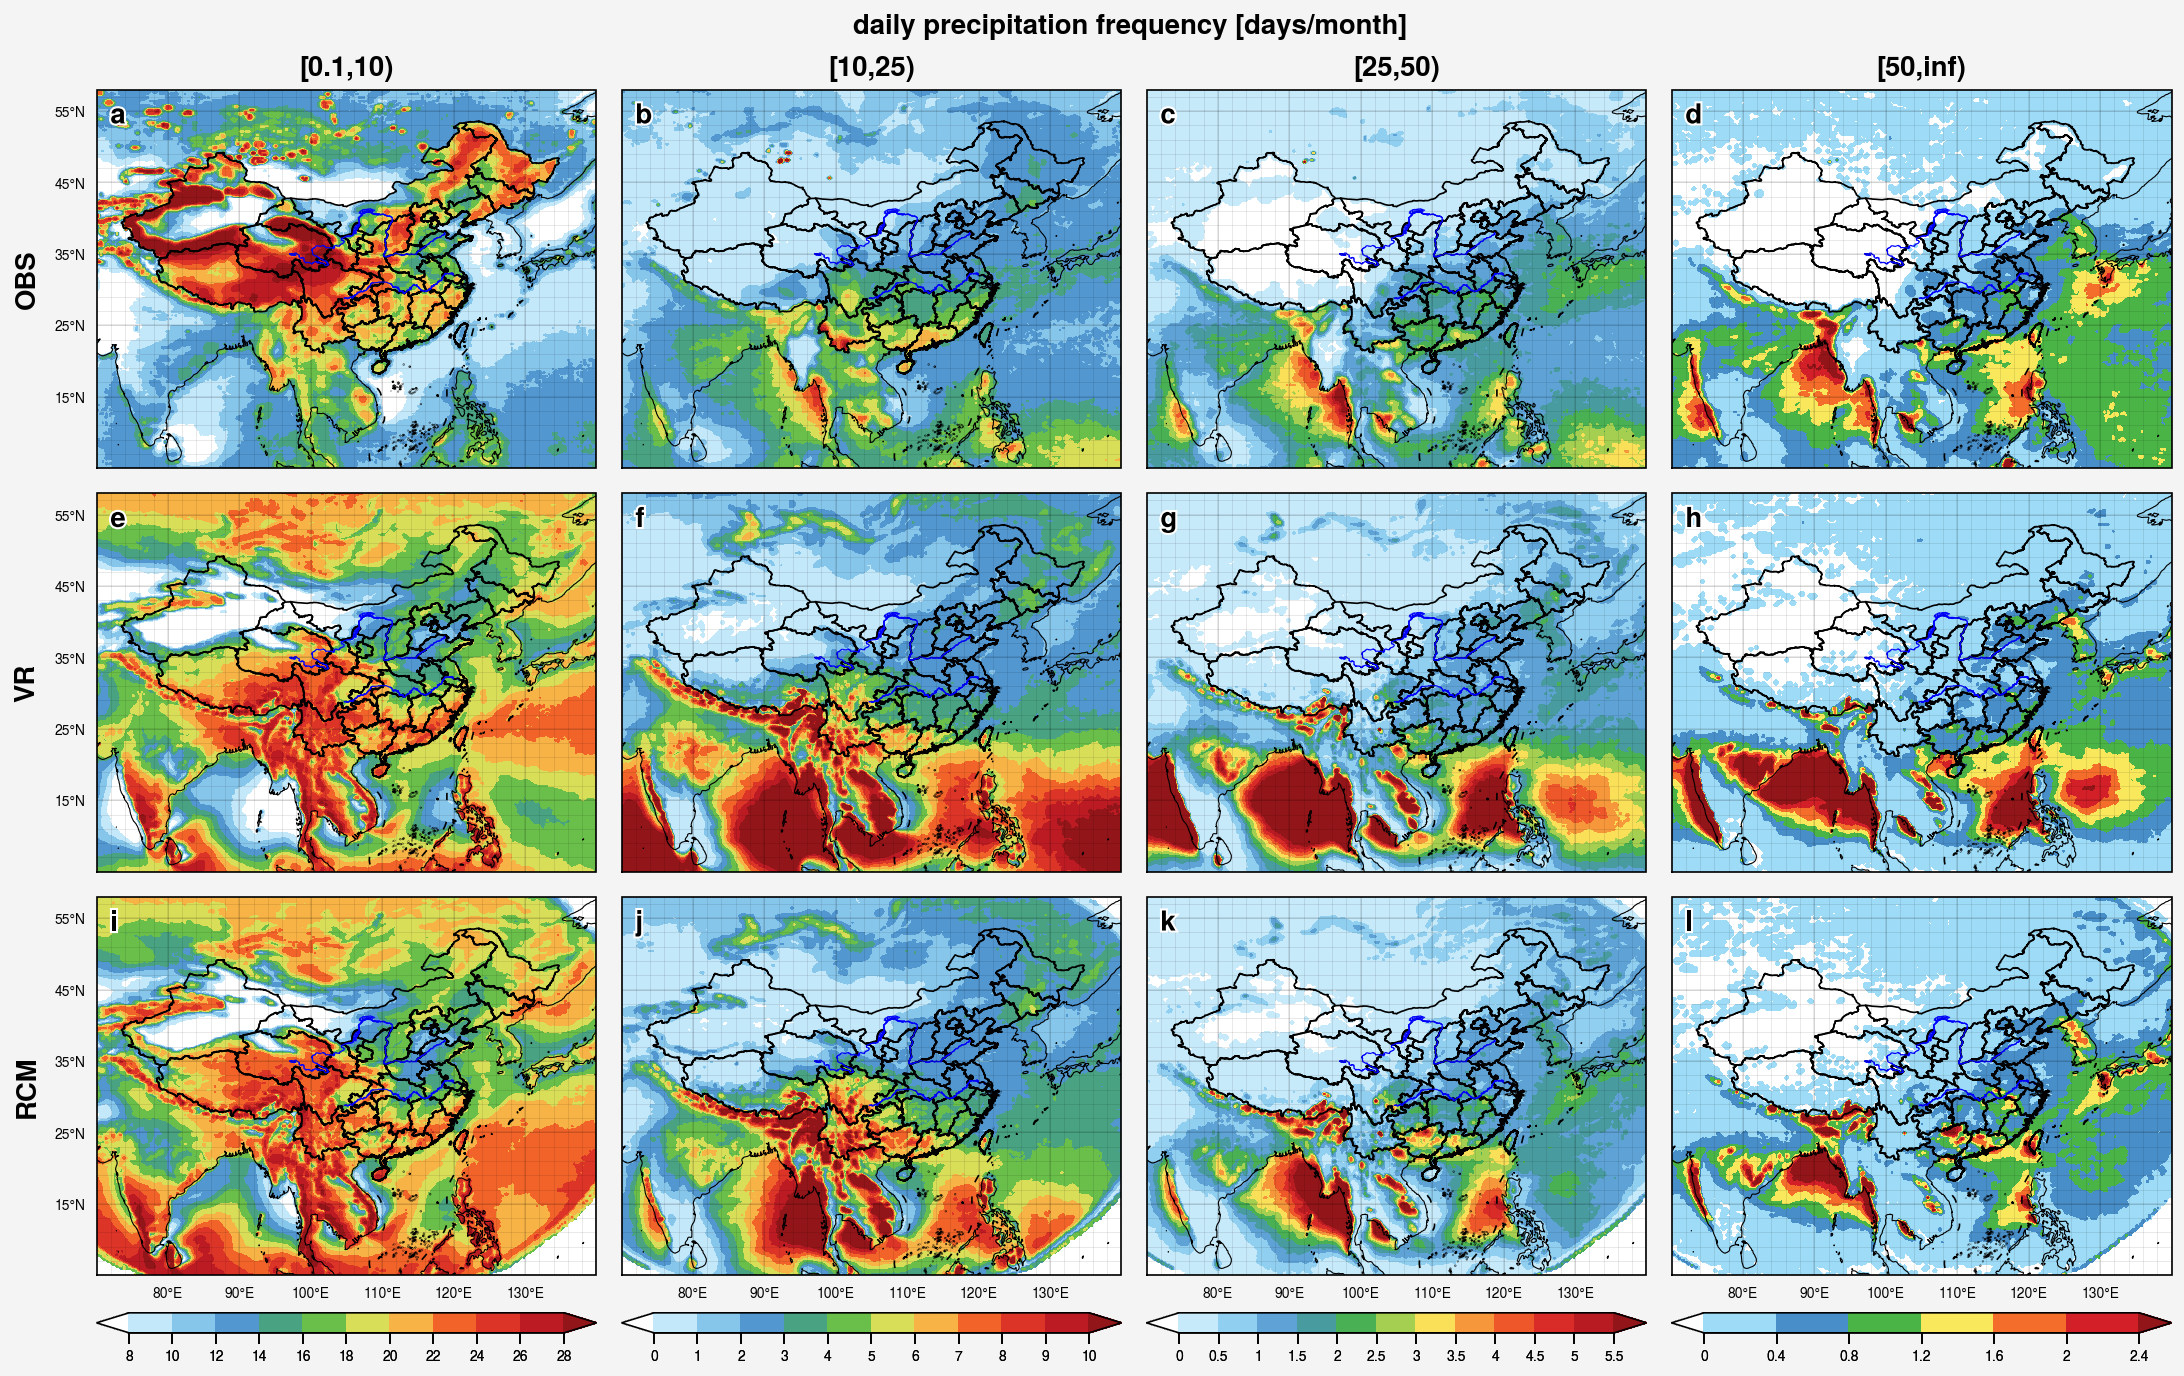

In [8]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
import cmaps
# ----- get filter vars coords-----

lon = var_interval[(0.1,10)]['vr'].lon.values
lat = var_interval[(0.1,10)]['vr'].lat.values

#----- create plot -----
fig, axs = plot.subplots(ncols=4, nrows=3, proj=('cyl'))
m_contour_list = [] # 用于保存contour设置，后续设置colorbar使用

#----- 添加海洋以及行政区划 -----
border_plot(axs)

#----- colorbar ticks 统一设置 -----
# cmap = 'gist_ncar'
cmap = cmaps.WhiteBlueGreenYellowRed
# cmap = cmaps.wh_bl_gr_ye_re
# cmap = cmaps.precip3_16lev
# cmap_diff = cmaps.cmp_flux_r
# cmap_diff = cmaps.ncl_default_r
# cmap_diff = cmaps.precip4_diff_19lev
# cmap = cmaps.WhViBlGrYeOrRe
ticks_plot = {}
# ticks_plot[(0.1, 10000000000.0)] = np.arange(0,30,3)
ticks_plot[(0.1, 10)] = np.arange(8,30,2)
ticks_plot[(10, 25)] = np.arange(0,11,1)
ticks_plot[(25, 50)] = np.arange(0,6,.5)
ticks_plot[(50, float('inf'))] = np.arange(0,2.8,0.4)
# ticks_plot[(100, 200)] = np.arange(0,0.35,0.05)
# ticks_plot[(200, float('inf'))] = np.arange(0,0.1,0.01)

col_ind = 0
for single_interval in freq_interval:
    row_ind = 0
    for mod_name in ['obs','vr','rcm']:
        m_mean = axs[row_ind,col_ind].contourf(lon, lat, var_interval[single_interval][mod_name].values,cmap=cmap, extend = 'both', norm = 'segmented', levels=ticks_plot[single_interval])
        row_ind+=1
    axs[2,col_ind].colorbar(m_mean, loc='b', width=0.1, ticks=ticks_plot[single_interval],\
    ticklabelsize=5, extend = 'both')
    col_ind +=1

# ----- set label ----- #
col_ind = 0
for single_interval in freq_interval:
    if (single_interval[1] < 1e5):
        axs[0,col_ind].format(title = "[" + str(single_interval[0]) + "," + str(single_interval[1]) + ')')
    else:
        axs[0,col_ind].format(title = "[" + str(single_interval[0]) + "," + 'inf' + ')')
    col_ind = col_ind + 1


# ----- format setting -----
axs.format(
abc=True,
abcloc = 'ul',
#----- 地图底图设置 -----
# reso = 'x-hi',
reso = 'med',
# coast = False,
coast = True,
coastlinewidth = 0.4,
borders = False,
lakes = False,
land  = False,
ocean = False,
# cartopyautoextent = True, 
# borderslinewidth=.5,
labels = False,
longrid  = True,
latgrid  = True,
#-----GEO axis-----
lonlim=(70, 140), latlim=(5, 58),
gridlabelsize = 5,
gridminor = True,
lonlocator = np.arange(70,142,10),
latlocator = np.arange(5,70+2,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(5,70+2,2),
#-----line label-----
titleweight = 'bold',
# linewidth = 0.5,
suptitle="daily precipitation frequency [days/month] ",
# toplabels=('OBS', 'VR', 'RCM'),
leftlabels=('OBS', 'VR','RCM'),
)

# 合并子图之后控制边界的labels绘制
axs[:-1,0].format(labels = True, lonlabels = False, latlabels = True)
axs[-1,1:].format(labels = True, lonlabels = True, latlabels = False)
axs[-1,0].format(labels = True, lonlabels = True, latlabels = True)

plt.savefig("./output_pic/pre_SpatialFreqDist.2022.02.18.png", dpi = 600, facecolor = "white")